In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder, StandardScaler, minmax_scale
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torchvision.transforms import v2

from main_event import prepare_event_data, prepare_json_event_data
from models.transformer import Transformer
from models.custom_transformer import Transformer as C_Transformer
from models.main import get_model, test_model, train_model
from preprocessing import PreProcessing
from utils import (
    add_shot_prediction_features,
    calculate_velocity_acceleration,
    calculate_velocity_direction,
    get_frame_data,
    plot_accuracy_history,
    plot_confusion_matrix,
    calculate_player_ball_distances,
    track_closest_players,
    get_n_smallest_indices_sorted
)

## You'll see the data goes from 0 to 1 on each axis. The coordinate (0,0) is the top left, (1,1) is the bottom right, and (0.5,0.5) is the kick off point.

In [2]:
game_1_pre = PreProcessing()
game_1_data = game_1_pre.load_and_process_data(
    data_home="data/Sample_Game_1/Sample_Game_1_RawTrackingData_Home_Team.csv", 
    data_away="data/Sample_Game_1/Sample_Game_1_RawTrackingData_Away_Team.csv", 
    add_ball_data=True, 
    remove_ball_nan=False
)

In [3]:
game_2_pre = PreProcessing()
game_2_data = game_2_pre.load_and_process_data(
    data_home="data/Sample_Game_2/Sample_Game_2_RawTrackingData_Home_Team.csv", 
    data_away="data/Sample_Game_2/Sample_Game_2_RawTrackingData_Away_Team.csv", 
    add_ball_data=True, 
    remove_ball_nan=False
)

In [4]:
game_3_pre = PreProcessing()
game_3_data = game_3_pre.load_and_process_json_data(
    data_home_away="data/Sample_Game_3/Sample_Game_3_tracking.txt", 
    add_ball_data=True, 
    remove_ball_nan=False
)

In [5]:
# game_1_data.iloc[:, 25:-2] = -1 * game_1_data.iloc[:, 25:-2]
game_1_data

,Period,Frame,Time [s],Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,...,Away-Player21-x,Away-Player21-y,Away-Player22-x,Away-Player22-y,Away-Player23-x,Away-Player23-y,Away-Player24-x,Away-Player24-y,Ball-x,Ball-y
1,1.0,1.0,0.04,0.00082,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,...,0.55243,0.43269,0.50067,0.94322,0.43693,0.05002,0.37833,0.27383,0.45472,0.38709
2,1.0,2.0,0.08,0.00096,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,...,0.55243,0.43269,0.50067,0.94322,0.43693,0.05002,0.37833,0.27383,0.49645,0.40656
3,1.0,3.0,0.12,0.00114,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,...,0.55243,0.43269,0.50067,0.94322,0.43693,0.05002,0.37833,0.27383,0.53716,0.42556
4,1.0,4.0,0.16,0.00121,0.48238,0.32622,0.65317,0.33687,0.48988,0.30944,...,0.55236,0.43313,0.50034,0.94391,0.43644,0.05038,0.37756,0.27473,0.55346,0.42231
5,1.0,5.0,0.20,0.00129,0.48238,0.32597,0.65269,0.33664,0.49018,0.30948,...,0.55202,0.43311,0.50017,0.94434,0.43580,0.04977,0.37663,0.27543,0.55512,0.40570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145002,2.0,145002.0,5800.08,0.90614,0.45355,0.30044,0.68311,0.34157,0.64598,0.31228,...,0.10317,0.81976,0.19836,0.45137,0.29416,0.48874,0.35600,0.55371,0.03058,0.99726
145003,2.0,145003.0,5800.12,0.90550,0.45355,0.30044,0.68311,0.34127,0.64583,0.31230,...,0.10319,0.81960,0.19831,0.45182,0.29373,0.48836,0.35583,0.55283,0.03058,0.99726
145004,2.0,145004.0,5800.16,0.90492,0.45355,0.30044,0.68311,0.34089,0.64569,0.31214,...,0.10285,0.81944,0.19805,0.45200,0.29331,0.48800,0.35561,0.55254,0.03058,0.99726
145005,2.0,145005.0,5800.20,0.90456,0.45356,0.30044,0.68311,0.34056,0.64552,0.31171,...,0.10231,0.81944,0.19766,0.45237,0.29272,0.48789,0.35532,0.55243,0.03058,0.99726


In [6]:
# game_2_data.iloc[:, 25:-2] = -1 * game_2_data.iloc[:, 25:-2]
game_2_data

,Period,Frame,Time [s],Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,...,Away-Player21-x,Away-Player21-y,Away-Player22-x,Away-Player22-y,Away-Player23-x,Away-Player23-y,Away-Player24-x,Away-Player24-y,Ball-x,Ball-y
1,1.0,1.0,0.04,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
2,1.0,2.0,0.08,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
3,1.0,3.0,0.12,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
4,1.0,4.0,0.16,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
5,1.0,5.0,0.20,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141152,2.0,141152.0,5646.08,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,...,0.46751,1.05000,0.44966,0.41572,0.26855,0.61845,0.36760,0.12496,0.40958,-0.03891
141153,2.0,141153.0,5646.12,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,...,0.46790,1.05000,0.44983,0.41550,0.26855,0.61845,0.36760,0.12496,0.40958,-0.03891
141154,2.0,141154.0,5646.16,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,...,0.46818,1.05000,0.44997,0.41485,0.26855,0.61845,0.36760,0.12496,0.40958,-0.03891
141155,2.0,141155.0,5646.20,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,...,0.46855,1.05000,0.45017,0.41515,0.26855,0.61845,0.36760,0.12496,0.40958,-0.03891


In [7]:
game_3_data

,Frame,Time [s],Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,Home-Player3-y,...,Away-Player21-x,Away-Player21-y,Away-Player22-x,Away-Player22-y,Away-Player23-x,Away-Player23-y,Away-Player24-x,Away-Player24-y,Ball-x,Ball-y
1,1,0.04,0.84722,0.52855,0.65268,0.24792,0.66525,0.46562,0.68103,0.59083,...,0.41787,0.48086,0.41215,0.36689,0.47050,0.73219,0.48864,0.36357,0.50125,0.48725
2,2,0.08,0.84722,0.52855,0.65231,0.24513,0.66482,0.46548,0.68095,0.59054,...,0.41719,0.47864,0.41132,0.36169,0.47040,0.73204,0.48834,0.36362,0.50125,0.48725
3,3,0.12,0.84722,0.52855,0.65197,0.24387,0.66467,0.46537,0.68078,0.59035,...,0.41697,0.47824,0.41131,0.36072,0.47075,0.73229,0.48814,0.36372,0.50125,0.48725
4,4,0.16,0.84722,0.52855,0.65166,0.24288,0.66460,0.46488,0.68063,0.58987,...,0.41685,0.47815,0.41117,0.35930,0.47118,0.73266,0.48793,0.36278,0.50125,0.48725
5,5,0.20,0.84722,0.52855,0.65141,0.24251,0.66452,0.46469,0.68052,0.58934,...,0.41669,0.47749,0.41120,0.35910,0.47163,0.73287,0.48784,0.36240,0.50125,0.48725
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143757,143757,5750.28,0.11993,0.51783,0.47808,0.45408,0.49691,0.77311,0.46373,0.62102,...,0.58877,0.56936,0.50218,0.65158,0.46978,0.62349,0.80792,0.27106,0.89207,0.50485
143758,143758,5750.32,0.11993,0.51783,0.47786,0.45521,0.49701,0.77429,0.46381,0.62046,...,0.58787,0.56961,0.50180,0.65115,0.46970,0.62403,0.80712,0.27184,0.89207,0.50485
143759,143759,5750.36,0.11993,0.51783,0.47743,0.45709,0.49686,0.77555,0.46358,0.62117,...,0.58668,0.57038,0.50116,0.65071,0.46929,0.62479,0.80582,0.27242,0.89207,0.50485
143760,143760,5750.40,0.11993,0.51783,0.47669,0.45947,0.49676,0.77638,0.46306,0.62339,...,0.58525,0.57033,0.50031,0.65134,0.46866,0.62611,0.80444,0.27260,0.89207,0.50485


## Tracking for individual Players for the First Period

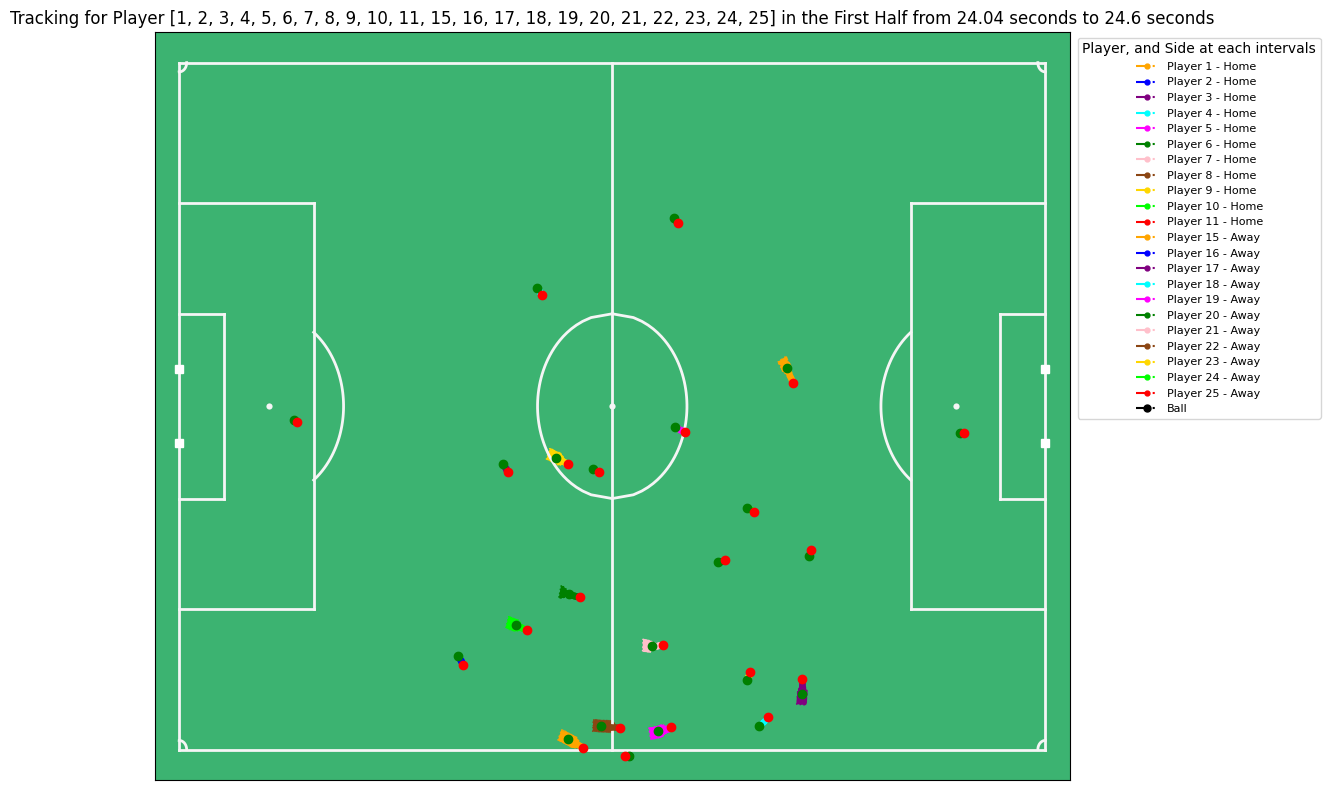

In [8]:
sides = ["Home"] * 11 + ["Away"] * 11
players = list(range(1, 12)) + list(range(15, 26))
game_2_pre.player_visualization(game_2_data.iloc[600:615], players=players, sides=sides, plot_ball=True)
# game_2_pre.player_visualization(game_2_data.iloc[2:3], players=[1,2,3,4,5,6,7,8,9,10,11], sides=["Home"]*11, plot_ball=False)

# Adding extra features to dataset

In [9]:
def calculate_velocity_acceleration_direction(dataset: pd.DataFrame, normalize: bool = True) -> pd.DataFrame:
    """
    Calculates the velocity, acceleration and direction of players and ball in a given dataset.

    Parameters:
        dataset (pandas.DataFrame): The input dataset containing player and ball positions over time.
        normalize (bool): Whether to normalize the calculated values.

    Returns:
        pandas.DataFrame: The original dataset with additional columns for velocity, acceleration and direction.
    """
    temp_data = dataset.copy()
    start_idx = temp_data.columns.get_loc("Time [s]")
    player_columns = temp_data.columns[start_idx + 1:]
    
    # Store all velocities/accelerations for global scaling
    all_velocities = []
    all_accelerations = []
    player_vel_mapping = {}
    player_acc_mapping = {}
    player_sin_mapping = {}
    player_cos_mapping = {}
    
    # First calculate all values
    for i in range(0, player_columns.shape[0] - 1, 2):
        ply_x, ply_y = player_columns[i], player_columns[i + 1]
        
        x_diff = temp_data[ply_x].diff()
        y_diff = temp_data[ply_y].diff()
        time_diff = temp_data["Frame"].diff()
        
        distance = np.sqrt(x_diff ** 2 + y_diff ** 2)
        velocity = distance / time_diff
        acceleration = velocity.diff() / time_diff
        
        # Calculate direction
        vel_x = x_diff / time_diff
        vel_y = y_diff / time_diff
        direction_rad = np.arctan2(vel_y, vel_x)
        
        direction_sine = np.sin(direction_rad)
        direction_cosine = np.cos(direction_rad)
        
        # Store values for later scaling and ordering
        if "ball" in str(ply_x).lower():
            entity = "Ball"
                
            player_vel_mapping[entity] = velocity
            player_acc_mapping[entity] = acceleration
            player_sin_mapping[entity] = direction_sine
            player_cos_mapping[entity] = direction_cosine
            
            all_velocities.extend(velocity.dropna().tolist())
            all_accelerations.extend(acceleration.dropna().tolist())
    
    # Apply global scaling if requested
    if normalize:
        # scaler_vel = MinMaxScaler(feature_range=(-1, 1))
        # scaler_acc = MinMaxScaler(feature_range=(-1, 1))
        scaler_vel = StandardScaler()
        scaler_acc = StandardScaler()
        
        # Fit the scalers on all values
        scaler_vel.fit(np.array(all_velocities).reshape(-1, 1))
        scaler_acc.fit(np.array(all_accelerations).reshape(-1, 1))
        
        # Transform the values
        for entity in player_vel_mapping:
            player_vel_mapping[entity] = scaler_vel.transform(player_vel_mapping[entity].values.reshape(-1, 1)).flatten()
            player_acc_mapping[entity] = scaler_acc.transform(player_acc_mapping[entity].values.reshape(-1, 1)).flatten()
    
    # Add columns to dataframe in the desired order: velocity, acceleration, direction
    for entity in player_vel_mapping.keys():  # Sort to ensure consistent order
        temp_data[f"{entity}_velocity"] = player_vel_mapping[entity]
        temp_data[f"{entity}_acceleration"] = player_acc_mapping[entity]
        temp_data[f"{entity}_direction_sin"] = player_sin_mapping[entity]
        temp_data[f"{entity}_direction_cos"] = player_cos_mapping[entity]
    
    return temp_data

In [10]:
vel_acc_game_1_data = calculate_velocity_acceleration_direction(game_1_data)
vel_acc_game_2_data = calculate_velocity_acceleration_direction(game_2_data)
vel_acc_game_3_data = calculate_velocity_acceleration_direction(game_3_data)

In [11]:
vel_acc_game_2_data

,Period,Frame,Time [s],Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,...,Away-Player23-x,Away-Player23-y,Away-Player24-x,Away-Player24-y,Ball-x,Ball-y,Ball_velocity,Ball_acceleration,Ball_direction_sin,Ball_direction_cos
1,1.0,1.0,0.04,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376,NaN,NaN,<NA>,<NA>
2,1.0,2.0,0.08,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376,-0.680811,NaN,0.0,1.0
3,1.0,3.0,0.12,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376,-0.680811,-4.228510e-19,0.0,1.0
4,1.0,4.0,0.16,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376,-0.680811,-4.228510e-19,0.0,1.0
5,1.0,5.0,0.20,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376,-0.680811,-4.228510e-19,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141152,2.0,141152.0,5646.08,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,...,0.26855,0.61845,0.36760,0.12496,0.40958,-0.03891,-0.680811,-4.228510e-19,0.0,1.0
141153,2.0,141153.0,5646.12,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,...,0.26855,0.61845,0.36760,0.12496,0.40958,-0.03891,-0.680811,-4.228510e-19,0.0,1.0
141154,2.0,141154.0,5646.16,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,...,0.26855,0.61845,0.36760,0.12496,0.40958,-0.03891,-0.680811,-4.228510e-19,0.0,1.0
141155,2.0,141155.0,5646.20,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,...,0.26855,0.61845,0.36760,0.12496,0.40958,-0.03891,-0.680811,-4.228510e-19,0.0,1.0


In [12]:
game_1_ply_tra = vel_acc_game_1_data.iloc[:, 3:]
game_2_ply_tra = vel_acc_game_2_data.iloc[:, 3:]
game_3_ply_tra = vel_acc_game_3_data.iloc[:, 2:] # This is different

In [13]:
game_2_ply_tra

,Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,Home-Player3-y,Home-Player4-x,Home-Player4-y,...,Away-Player23-x,Away-Player23-y,Away-Player24-x,Away-Player24-y,Ball-x,Ball-y,Ball_velocity,Ball_acceleration,Ball_direction_sin,Ball_direction_cos
1,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,...,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376,NaN,NaN,<NA>,<NA>
2,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,...,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376,-0.680811,NaN,0.0,1.0
3,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,...,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376,-0.680811,-4.228510e-19,0.0,1.0
4,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,...,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376,-0.680811,-4.228510e-19,0.0,1.0
5,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,...,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376,-0.680811,-4.228510e-19,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141152,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,0.32209,0.40837,0.14449,...,0.26855,0.61845,0.36760,0.12496,0.40958,-0.03891,-0.680811,-4.228510e-19,0.0,1.0
141153,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,0.32209,0.40837,0.14449,...,0.26855,0.61845,0.36760,0.12496,0.40958,-0.03891,-0.680811,-4.228510e-19,0.0,1.0
141154,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,0.32209,0.40837,0.14449,...,0.26855,0.61845,0.36760,0.12496,0.40958,-0.03891,-0.680811,-4.228510e-19,0.0,1.0
141155,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,0.32209,0.40837,0.14449,...,0.26855,0.61845,0.36760,0.12496,0.40958,-0.03891,-0.680811,-4.228510e-19,0.0,1.0


In [14]:
# game_1_player_data = get_frame_data(game_1_ply_tra, columns=game_1_ply_tra.columns[0:46:2], feature="direction").fillna(0)
# game_2_player_data = get_frame_data(game_2_ply_tra, columns=game_2_ply_tra.columns[0:46:2], feature="direction").fillna(0)
# game_3_player_data = get_frame_data(game_3_ply_tra, columns=game_3_ply_tra.columns[0:46:2], feature="direction").fillna(0)

In [15]:
game_1_player_data = game_1_ply_tra.fillna(0).copy()
game_2_player_data = game_2_ply_tra.fillna(0).copy()
game_3_player_data = game_3_ply_tra.fillna(0).copy()

In [16]:
game_1_player_data

,Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,Home-Player3-y,Home-Player4-x,Home-Player4-y,...,Away-Player23-x,Away-Player23-y,Away-Player24-x,Away-Player24-y,Ball-x,Ball-y,Ball_velocity,Ball_acceleration,Ball_direction_sin,Ball_direction_cos
1,0.00082,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,0.35529,0.32137,0.21262,...,0.43693,0.05002,0.37833,0.27383,0.45472,0.38709,0.000000,0.000000,0.0,0.0
2,0.00096,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,0.35529,0.32137,0.21262,...,0.43693,0.05002,0.37833,0.27383,0.49645,0.40656,11.611314,0.000000,0.422814,0.906216
3,0.00114,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,0.35529,0.32137,0.21262,...,0.43693,0.05002,0.37833,0.27383,0.53716,0.42556,11.313757,-0.325623,0.422922,0.906166
4,0.00121,0.48238,0.32622,0.65317,0.33687,0.48988,0.30944,0.35554,0.32142,0.21241,...,0.43644,0.05038,0.37756,0.27473,0.55346,0.42231,3.814385,-8.208957,-0.195538,0.980696
5,0.00129,0.48238,0.32597,0.65269,0.33664,0.49018,0.30948,0.35528,0.32136,0.21159,...,0.43580,0.04977,0.37663,0.27543,0.55512,0.40570,3.833435,0.020944,-0.995043,0.099444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145002,0.90614,0.45355,0.30044,0.68311,0.34157,0.64598,0.31228,0.67513,0.11428,0.92765,...,0.29416,0.48874,0.35600,0.55371,0.03058,0.99726,-0.589333,0.000092,0.0,1.0
145003,0.90550,0.45355,0.30044,0.68311,0.34127,0.64583,0.31230,0.67529,0.11428,0.92765,...,0.29373,0.48836,0.35583,0.55283,0.03058,0.99726,-0.589333,0.000092,0.0,1.0
145004,0.90492,0.45355,0.30044,0.68311,0.34089,0.64569,0.31214,0.67501,0.11428,0.92765,...,0.29331,0.48800,0.35561,0.55254,0.03058,0.99726,-0.589333,0.000092,0.0,1.0
145005,0.90456,0.45356,0.30044,0.68311,0.34056,0.64552,0.31171,0.67468,0.11428,0.92765,...,0.29272,0.48789,0.35532,0.55243,0.03058,0.99726,-0.589333,0.000092,0.0,1.0


In [17]:
game_1_player_data = add_shot_prediction_features(game_1_player_data)
game_2_player_data = add_shot_prediction_features(game_2_player_data)
game_3_player_data = add_shot_prediction_features(game_3_player_data)

In [18]:
game_1_player_data

,Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,Home-Player3-y,Home-Player4-x,Home-Player4-y,...,Away-Player24-x,Away-Player24-y,Ball-x,Ball-y,Ball_velocity,Ball_acceleration,Ball_direction_sin,Ball_direction_cos,Ball_nearest_goal_distance,Ball_shot_probability
1,0.00082,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,0.35529,0.32137,0.21262,...,0.37833,0.27383,0.45472,0.38709,0.000000,0.000000,0.0,0.0,0.468528,0.0
2,0.00096,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,0.35529,0.32137,0.21262,...,0.37833,0.27383,0.49645,0.40656,11.611314,0.000000,0.422814,0.906216,0.505167,0.0
3,0.00114,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,0.35529,0.32137,0.21262,...,0.37833,0.27383,0.53716,0.42556,11.313757,-0.325623,0.422922,0.906166,0.468788,0.0
4,0.00121,0.48238,0.32622,0.65317,0.33687,0.48988,0.30944,0.35554,0.32142,0.21241,...,0.37756,0.27473,0.55346,0.42231,3.814385,-8.208957,-0.195538,0.980696,0.453248,0.0
5,0.00129,0.48238,0.32597,0.65269,0.33664,0.49018,0.30948,0.35528,0.32136,0.21159,...,0.37663,0.27543,0.55512,0.40570,3.833435,0.020944,-0.995043,0.099444,0.454764,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145002,0.90614,0.45355,0.30044,0.68311,0.34157,0.64598,0.31228,0.67513,0.11428,0.92765,...,0.35600,0.55371,0.03058,0.99726,-0.589333,0.000092,0.0,1.0,0.498199,0.0
145003,0.90550,0.45355,0.30044,0.68311,0.34127,0.64583,0.31230,0.67529,0.11428,0.92765,...,0.35583,0.55283,0.03058,0.99726,-0.589333,0.000092,0.0,1.0,0.498199,0.0
145004,0.90492,0.45355,0.30044,0.68311,0.34089,0.64569,0.31214,0.67501,0.11428,0.92765,...,0.35561,0.55254,0.03058,0.99726,-0.589333,0.000092,0.0,1.0,0.498199,0.0
145005,0.90456,0.45356,0.30044,0.68311,0.34056,0.64552,0.31171,0.67468,0.11428,0.92765,...,0.35532,0.55243,0.03058,0.99726,-0.589333,0.000092,0.0,1.0,0.498199,0.0


# Classification

In [19]:
game_1_event = prepare_event_data("data/Sample_Game_1/Sample_Game_1_RawEventsData.csv", game_1_data)
game_2_event = prepare_event_data("data/Sample_Game_2/Sample_Game_2_RawEventsData.csv", game_2_data)
game_3_event = prepare_json_event_data("data/Sample_Game_3/Sample_Game_3_events.json", game_3_data)

In [20]:
game_1_event

,Type
3,PASS
4,PASS
5,PASS
6,PASS
7,PASS
...,...
143614,BALL LOST
143615,BALL LOST
143616,BALL LOST
143617,BALL LOST


In [21]:
game_2_event

,Type
146,PASS
147,PASS
148,PASS
149,PASS
150,PASS
...,...
141152,BALL OUT
141153,BALL OUT
141154,BALL OUT
141155,BALL OUT


In [22]:
game_3_event

,Type
384,PASS
385,PASS
386,PASS
387,PASS
388,PASS
...,...
143529,PASS
143530,PASS
143531,PASS
143532,PASS


In [23]:
common_indices = game_1_event.index.intersection(game_1_player_data.index)
X_1 = game_1_player_data.loc[common_indices]
y_1 = game_1_event.loc[common_indices]

assert X_1.shape[0] == y_1.shape[0]

In [24]:
common_indices = game_2_event.index.intersection(game_2_player_data.index)
X_2 = game_2_player_data.loc[common_indices]
y_2 = game_2_event.loc[common_indices]

assert X_2.shape[0] == y_2.shape[0]

In [25]:
common_indices = game_3_event.index.intersection(game_3_player_data.index)
X_3 = game_3_player_data.loc[common_indices]
y_3 = game_3_event.loc[common_indices]

assert X_3.shape[0] == y_3.shape[0]

In [26]:
X_3

,Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,Home-Player3-y,Home-Player4-x,Home-Player4-y,...,Away-Player24-x,Away-Player24-y,Ball-x,Ball-y,Ball_velocity,Ball_acceleration,Ball_direction_sin,Ball_direction_cos,Ball_nearest_goal_distance,Ball_shot_probability
384,0.84896,0.50882,0.63285,0.18320,0.73758,0.39566,0.71792,0.66465,0.55429,0.91139,...,0.49816,0.36762,0.49724,0.48532,-0.686549,-1.134310e-02,-0.824729,-0.565528,0.497457,0.0
385,0.84939,0.50864,0.63267,0.18279,0.73773,0.39606,0.71791,0.66512,0.55430,0.91192,...,0.49900,0.36807,0.49885,0.48702,-0.067931,9.812472e-01,0.726065,0.687626,0.499019,0.0
386,0.84987,0.50834,0.63248,0.18255,0.73789,0.39654,0.71791,0.66555,0.55430,0.91241,...,0.49986,0.36846,0.50207,0.49054,0.715981,1.243436e+00,0.737850,0.674965,0.498020,0.0
387,0.85034,0.50816,0.63230,0.18221,0.73806,0.39692,0.71791,0.66600,0.55430,0.91292,...,0.50075,0.36886,0.50528,0.49406,0.713805,-3.451980e-03,0.738894,0.673821,0.494756,0.0
388,0.85080,0.50799,0.63211,0.18188,0.73820,0.39735,0.71787,0.66652,0.55428,0.91342,...,0.50167,0.36927,0.50850,0.49757,0.713602,-3.223625e-04,0.736893,0.676010,0.491506,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143529,0.11993,0.51783,0.42811,0.48741,0.43863,0.79777,0.43239,0.63392,0.43707,0.32970,...,0.75468,0.20334,0.87713,0.53311,1.140643,9.264912e-20,-0.893769,0.448527,0.127253,0.0
143530,0.11993,0.51783,0.42872,0.48704,0.43895,0.79718,0.43311,0.63370,0.43740,0.32903,...,0.75576,0.20261,0.87985,0.52767,1.139198,-2.292491e-03,-0.894427,0.447214,0.123295,0.0
143531,0.11993,0.51783,0.42932,0.48660,0.43928,0.79654,0.43382,0.63342,0.43772,0.32837,...,0.75687,0.20178,0.88258,0.52223,1.140643,2.292491e-03,-0.893769,0.448527,0.119506,0.0
143532,0.11993,0.51783,0.42993,0.48618,0.43961,0.79595,0.43452,0.63314,0.43802,0.32764,...,0.75800,0.20099,0.88531,0.51679,1.140643,9.264912e-20,-0.893769,0.448527,0.115912,0.0


### Adding which team has the ball using distance metrics

In [27]:
def add_team_with_ball(event_df, full_data):
    events_to_leave_out=["FAULT RECEIVED", "SET PIECE", "CARD", "CHALLENGE"]
    game_event_data = pd.read_csv(event_df)    
    game_event_data = game_event_data[~(game_event_data["Type"].isin(events_to_leave_out))]
    event_data = game_event_data.replace("RECOVERY", "BALL LOST")    

    ball_out_idx = full_data.index[
        (full_data["Ball-x"] < 0) | (full_data["Ball-x"] > 1) |
        (full_data["Ball-y"] < 0) | (full_data["Ball-y"] > 1)
    ]

    ball_out_df = pd.DataFrame({
        "Team": "BALL OUT"
    }, index=ball_out_idx)
    
    event_data = event_data[~(event_data["Type"] == "BALL OUT")]
    start_frames = event_data["Start Frame"].iloc[1:].to_numpy()
    end_frames = event_data["End Frame"].iloc[1:].to_numpy()
    event_types = event_data["Team"].iloc[1:].to_numpy()

    # Validation
    assert start_frames.shape == end_frames.shape == event_types.shape

    # Ensure end frames don't exceed data bounds
    end = full_data.index[-1]
    end_frames = np.minimum(end_frames, end)

    # Create frame ranges and unique indices
    frame_ranges = [np.arange(min(i, j), max(i, j) + 1)
                    for i, j in zip(start_frames, end_frames)]
    unique_indices = np.unique(np.concatenate(frame_ranges))

    # Create and populate event DataFrame
    event_df = pd.DataFrame(index=unique_indices, columns=["Team"])
    for s, e, e_t in zip(start_frames, end_frames, event_types):
        event_df.loc[s:e, "Team"] = e_t
        
    combined_event_df = ball_out_df.combine_first(event_df)
    
    return replace_c_with_previous(combined_event_df.dropna())

In [28]:
def add_team_with_ball_json(event_df, full_data):
    import json

    with open(event_df, "r") as f:
        event = json.load(f)
        
    type_ = np.array([])
    team_ = np.array([])
    start_frame = np.array([])
    end_frame = np.array([])
    
    for i in event["data"]:
        t = i["type"]["name"]
        te = i["team"]["name"]
        sf = i["start"]["frame"]
        ef = i["end"]["frame"]
    
        if t != "CARRY" and t != "BALL OUT":
            type_ = np.append(type_, t)
            team_ = np.append(team_, te)
            start_frame = np.append(start_frame, sf)
            end_frame = np.append(end_frame, ef)
    
    
    game_event_data = pd.DataFrame({"Type": type_, "Team": team_, "Start Frame": start_frame.astype(np.int64), "End Frame": end_frame.astype(np.int64)})
    events_to_leave_out=["FAULT RECEIVED", "SET PIECE", "CARD", "CHALLENGE"]

    game_event_data = game_event_data[~(game_event_data["Type"].isin(events_to_leave_out))]


    event_data = game_event_data.replace("RECOVERY", "BALL LOST")
    ball_out_idx = full_data.index[
        (full_data["Ball-x"] < 0) | (full_data["Ball-x"] > 1) |
        (full_data["Ball-y"] < 0) | (full_data["Ball-y"] > 1)
    ]

    ball_out_df = pd.DataFrame({
        "Team": "BALL OUT"
    }, index=ball_out_idx)
    
    event_data = event_data[~(event_data["Type"] == "BALL OUT")]
    start_frames = event_data["Start Frame"].iloc[1:].to_numpy()
    end_frames = event_data["End Frame"].iloc[1:].to_numpy()
    event_types = event_data["Team"].iloc[1:].to_numpy()

    # Validation
    assert start_frames.shape == end_frames.shape == event_types.shape

    # Ensure end frames don't exceed data bounds
    end = full_data.index[-1]
    end_frames = np.minimum(end_frames, end)

    # Create frame ranges and unique indices
    frame_ranges = [np.arange(min(i, j), max(i, j) + 1)
                    for i, j in zip(start_frames, end_frames)]
    unique_indices = np.unique(np.concatenate(frame_ranges))

    # Create and populate event DataFrame
    event_df = pd.DataFrame(index=unique_indices, columns=["Team"])
    for s, e, e_t in zip(start_frames, end_frames, event_types):
        event_df.loc[s:e, "Team"] = e_t
        
    combined_event_df = ball_out_df.combine_first(event_df)
    
    return replace_c_with_previous(combined_event_df.dropna())

In [29]:
def replace_c_with_previous(df):
    prev_value = None
    new_types = []

    for val in df['Team']:
        if val != 'BALL OUT':
            prev_value = val
            new_types.append(val)
        else:
            new_types.append(prev_value)

    df['Team'] = new_types
    return df

In [30]:
def add_ball_with(closest_to_ball: pd.DataFrame):
    # Assume the column of interest is the first column.
    col = closest_to_ball.iloc[:, 0].str.lower()
    
    # Use numpy.where to vectorize the assignment.
    team = np.where(col.str.startswith("home"), 0, 
                    np.where(col.str.startswith("away"), 1, np.nan))
    
    return team

def add_ball_with_json(closest_to_ball: pd.DataFrame):
    # Assume the column of interest is the first column.
    col = closest_to_ball.iloc[:, 0].str.lower()
    
    # Use numpy.where to vectorize the assignment.
    team = np.where(col.str.startswith("team a"), 0, 
                    np.where(col.str.startswith("team b"), 1, np.nan))
    
    return team

In [31]:
X_1["Team"] = add_ball_with(add_team_with_ball("data/Sample_Game_1/Sample_Game_1_RawEventsData.csv", game_1_data))
X_2["Team"] = add_ball_with(add_team_with_ball("data/Sample_Game_2/Sample_Game_2_RawEventsData.csv", game_2_data))
X_3["Team"] = add_ball_with_json(add_team_with_ball_json("data/Sample_Game_3/Sample_Game_3_events.json", game_3_data))

In [32]:
X_1

,Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,Home-Player3-y,Home-Player4-x,Home-Player4-y,...,Away-Player24-y,Ball-x,Ball-y,Ball_velocity,Ball_acceleration,Ball_direction_sin,Ball_direction_cos,Ball_nearest_goal_distance,Ball_shot_probability,Team
3,0.00114,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,0.35529,0.32137,0.21262,...,0.27383,0.53716,0.42556,11.313757,-0.325623,0.422922,0.906166,0.468788,0.0,1.0
4,0.00121,0.48238,0.32622,0.65317,0.33687,0.48988,0.30944,0.35554,0.32142,0.21241,...,0.27473,0.55346,0.42231,3.814385,-8.208957,-0.195538,0.980696,0.453248,0.0,1.0
5,0.00129,0.48238,0.32597,0.65269,0.33664,0.49018,0.30948,0.35528,0.32136,0.21159,...,0.27543,0.55512,0.40570,3.833435,0.020944,-0.995043,0.099444,0.454764,0.0,1.0
6,0.00140,0.48238,0.32581,0.65159,0.33637,0.48966,0.30978,0.35479,0.32159,0.21051,...,0.27673,0.55677,0.38909,3.833172,-0.000195,-0.995102,0.098851,0.456896,0.0,1.0
7,0.00140,0.48238,0.32570,0.65037,0.33624,0.48919,0.31015,0.35439,0.32198,0.20921,...,0.27751,0.55842,0.37248,3.833172,0.000092,-0.995102,0.098851,0.459624,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143614,0.87621,0.48890,0.25147,0.54818,0.47196,0.44820,0.50936,0.57808,0.11104,0.67714,...,0.56158,0.08382,0.62709,0.755895,-0.001732,-0.777978,-0.628291,0.152242,1.0,0.0
143615,0.87601,0.48911,0.25096,0.54821,0.47157,0.44844,0.50890,0.57796,0.11004,0.67616,...,0.56196,0.08062,0.62314,0.757562,0.001916,-0.777016,-0.629481,0.147184,1.0,0.0
143616,0.87583,0.48933,0.25045,0.54823,0.47120,0.44872,0.50844,0.57788,0.10914,0.67526,...,0.56233,0.07743,0.61919,0.755895,-0.001732,-0.777978,-0.628291,0.142133,1.0,0.0
143617,0.87564,0.48954,0.24996,0.54830,0.47084,0.44899,0.50799,0.57768,0.10829,0.67433,...,0.56268,0.07423,0.61523,0.759621,0.004171,-0.777793,-0.62852,0.137069,1.0,1.0


In [33]:
# away_cols = X_1.columns.str.startswith("Away")
# X_1.loc[:, away_cols] = X_1.loc[:, away_cols] * -1

# away_cols = X_2.columns.str.startswith("Away")
# X_2.loc[:, away_cols] = X_2.loc[:, away_cols] * -1

# away_cols = X_3.columns.str.startswith("Away")
# X_3.loc[:, away_cols] = X_3.loc[:, away_cols] * -1

In [34]:
# X_1

In [35]:
np.unique(y_1, return_counts=True)

(array(['BALL LOST', 'BALL OUT', 'PASS', 'SHOT'], dtype=object),
 array([10071, 19023, 28145,   546]))

In [36]:
np.unique(y_2, return_counts=True)

(array(['BALL LOST', 'BALL OUT', 'PASS', 'SHOT'], dtype=object),
 array([ 7742, 15537, 32338,   485]))

In [37]:
np.unique(y_3, return_counts=True)

(array(['BALL LOST', 'BALL OUT', 'PASS', 'SHOT'], dtype=object),
 array([11107, 19620, 42896,   391]))

In [38]:
scaler = StandardScaler()
X_1_scaled = X_1.iloc[:, :].values.astype(float)#scaler.fit_transform(X_1)
X_2_scaled = X_2.iloc[:, :].values.astype(float)#scaler.transform(X_2)
X_3_scaled = X_3.iloc[:, :].values.astype(float)#scaler.transform(X_3)

# X_1_scaled = minmax_scale(X_1, axis=1)
# X_2_scaled = minmax_scale(X_2, axis=1)
# X_3_scaled = minmax_scale(X_3, axis=1)

In [39]:
label_encoder = LabelEncoder()
y_1_encoded = label_encoder.fit_transform(y_1)
y_2_encoded = label_encoder.transform(y_2)
y_3_encoded = label_encoder.transform(y_3)

C:\Users\racr\Desktop\Million's workspace\Thesis-main\Thesis-main\Real-Time LLM Football Commentary\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\racr\Desktop\Million's workspace\Thesis-main\Thesis-main\Real-Time LLM Football Commentary\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
C:\Users\racr\Desktop\Million's workspace\Thesis-main\Thesis-main\Real-Time LLM Football Commentary\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y t

In [40]:
print(X_1_scaled.shape)
print(X_2_scaled.shape)
print(X_3_scaled.shape)

(57785, 53)
(56102, 53)
(74014, 53)


In [54]:
X_1_scaled = X_1_scaled[:(X_1_scaled.shape[0] - X_1_scaled.shape[0] % 200)]
y_1_encoded = y_1_encoded[:(y_1_encoded.shape[0] - y_1_encoded.shape[0] % 200)]

X_2_scaled = X_2_scaled[:(X_2_scaled.shape[0] - X_2_scaled.shape[0] % 200)]
y_2_encoded = y_2_encoded[:(y_2_encoded.shape[0] - y_2_encoded.shape[0] % 200)]

X_3_scaled = X_3_scaled[:(X_3_scaled.shape[0] - X_3_scaled.shape[0] % 200)]
y_3_encoded = y_3_encoded[:(y_3_encoded.shape[0] - y_3_encoded.shape[0] % 200)]

In [55]:
print(X_1_scaled.shape)
print(X_2_scaled.shape)
print(X_3_scaled.shape)

(57600, 53)
(56000, 53)
(74000, 53)


In [56]:
print(np.unique(y_1_encoded, return_counts=True))
print(np.unique(y_2_encoded, return_counts=True))
print(np.unique(y_3_encoded, return_counts=True))

(array([0, 1, 2, 3]), array([10050, 19023, 27981,   546]))
(array([0, 1, 2, 3]), array([ 7742, 15435, 32338,   485]))
(array([0, 1, 2, 3]), array([11106, 19620, 42883,   391]))


In [57]:
w_1 = np.unique(y_1_encoded, return_counts=True)[1] + np.unique(y_2_encoded, return_counts=True)[1]
w_2 = np.unique(y_3_encoded, return_counts=True)[1]

weight_1 = np.divide(w_1, w_1.sum(), dtype=np.float32)
weight_2 = np.divide(w_2, w_2.sum(), dtype=np.float32)

In [58]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    device_name = torch.cuda.get_device_name(device)
    print(f"Using {device}: {device_name}")
else:
    device = torch.device("cpu")
    print(f"Using {device} device")

Using cuda: NVIDIA GeForce RTX 4090


In [59]:
np.unique(y_1_encoded).shape, np.unique(y_2_encoded).shape, np.unique(y_3_encoded).shape

((4,), (4,), (4,))

In [60]:
# Define hyperparameters
transformer_params = {
    "input_size": X_1_scaled.shape[1],
    "d_model" : 128,
    "nhead" : 4,
    "num_encoder_layers" : 6,
    "num_decoder_layers" : 8,
    "dim_feedforward" : 128,
    "num_classes" : np.unique(y_1_encoded).shape[0],
    "dropout_rate": 0.1,
    "sequence_length": 50,
    "learning_rate": 0.001,
    "batch_size": 1024,
    "num_epochs": 150
}
input_size = transformer_params["input_size"]
sequence_length = transformer_params["sequence_length"]
learning_rate = transformer_params["learning_rate"]
batch_size = transformer_params["batch_size"]
num_epochs = transformer_params["num_epochs"]

In [61]:
class ToTensorSequential:
    def __call__(self, sample):
        X, y = sample['X'], sample['y']
        # Convert both features and labels to tensors
        return {
            'X': torch.tensor(X, dtype=torch.float32),
            'y': torch.tensor(y, dtype=torch.long)
        }
        
transform = v2.Compose([
    ToTensorSequential(),
])


class SequenceDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        sample = {"X": self.X[idx], "y": self.y[idx]}
        if self.transform:
            sample = self.transform(sample)
        return sample["X"], sample["y"]

In [62]:
X_comb = np.concatenate([X_3_scaled, X_2_scaled])
y_comb = np.concatenate((y_3_encoded, y_2_encoded))

X_comb_reshaped = X_comb.reshape(-1, sequence_length, input_size).astype(float)
y_comb_reshaped = y_comb.reshape(-1, sequence_length)

X_1_reshaped = X_1_scaled.reshape(-1, sequence_length, input_size).astype(float)
y_1_reshaped = y_1_encoded.reshape(-1, sequence_length) 

train_dataset = SequenceDataset(X_comb_reshaped, y_comb_reshaped, transform=transform)
validation_dataset = SequenceDataset(X_1_reshaped, y_1_reshaped, transform=transform)

train_loader = DataLoader(
    dataset=train_dataset, 
    batch_size=batch_size, 
    shuffle=False,
)

validation_loader = DataLoader(
    dataset=validation_dataset, 
    batch_size=batch_size, 
    shuffle=False,
)

In [63]:
transformer_model = get_model(Transformer, params=transformer_params).to(device)
transformer_model

Transformer(
  (encoder): TransformerEncoder(
    (input_projection): Linear(in_features=53, out_features=128, bias=True)
    (input_bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (positional_encoding): PositionalEncoding(
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
          )
          (linear1): Linear(in_features=128, out_features=128, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=128, out_features=128, bias=True)
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
        

In [64]:
weights = torch.from_numpy(weight_1).to(device)
acc, y_train, y_train_pred, y_true, y_pred = train_model(transformer_model, train_loader, validation_loader, num_epochs, "adam", nn.CrossEntropyLoss(weight=weights), learning_rate, device, is_transformer=True)

Epoch   1/150: Train accuracy: 70.30% | Val accuracy: 69.08% | Train loss: 0.6440 | Val loss: 0.5907 | learning rate: 0.001000 | Precision: 60.45% | Recall: 69.08% | F1: 62.21%
Epoch   2/150: Train accuracy: 74.46% | Val accuracy: 71.38% | Train loss: 0.4515 | Val loss: 0.7184 | learning rate: 0.001000 | Precision: 65.61% | Recall: 71.38% | F1: 66.79%
Epoch   3/150: Train accuracy: 87.90% | Val accuracy: 61.77% | Train loss: 0.1937 | Val loss: 1.0707 | learning rate: 0.001000 | Precision: 62.02% | Recall: 61.77% | F1: 59.89%
Epoch   4/150: Train accuracy: 92.06% | Val accuracy: 68.59% | Train loss: 0.1479 | Val loss: 0.9646 | learning rate: 0.001000 | Precision: 63.26% | Recall: 68.59% | F1: 64.72%
Epoch   5/150: Train accuracy: 92.76% | Val accuracy: 65.22% | Train loss: 0.1417 | Val loss: 1.0602 | learning rate: 0.001000 | Precision: 63.72% | Recall: 65.22% | F1: 63.20%
Epoch   6/150: Train accuracy: 93.11% | Val accuracy: 43.82% | Train loss: 0.1311 | Val loss: 1.5679 | learning rat

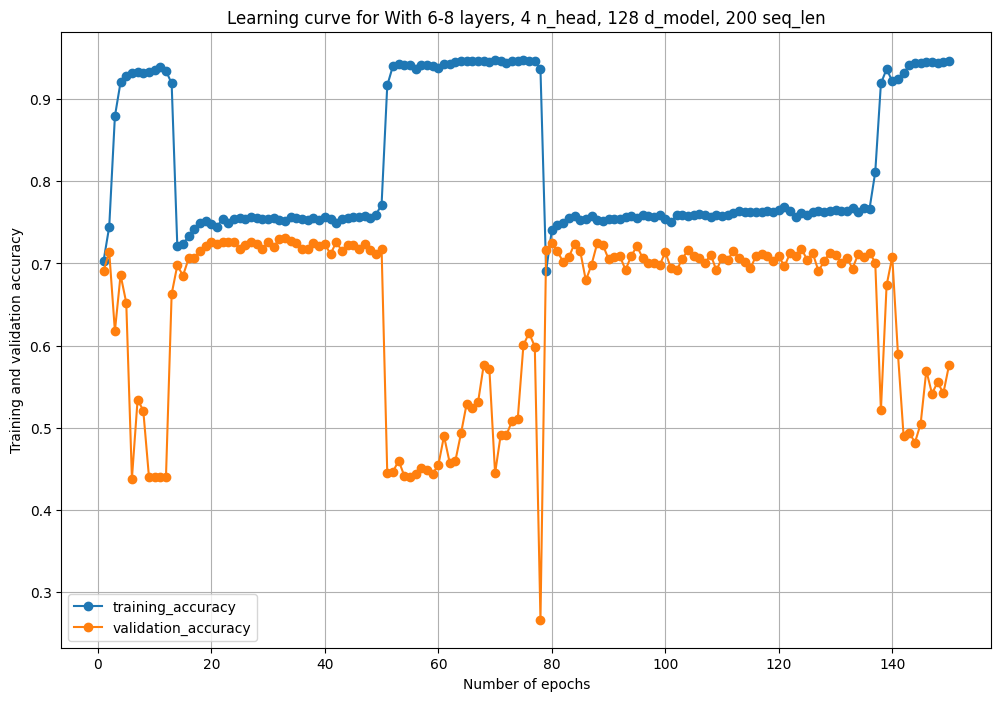

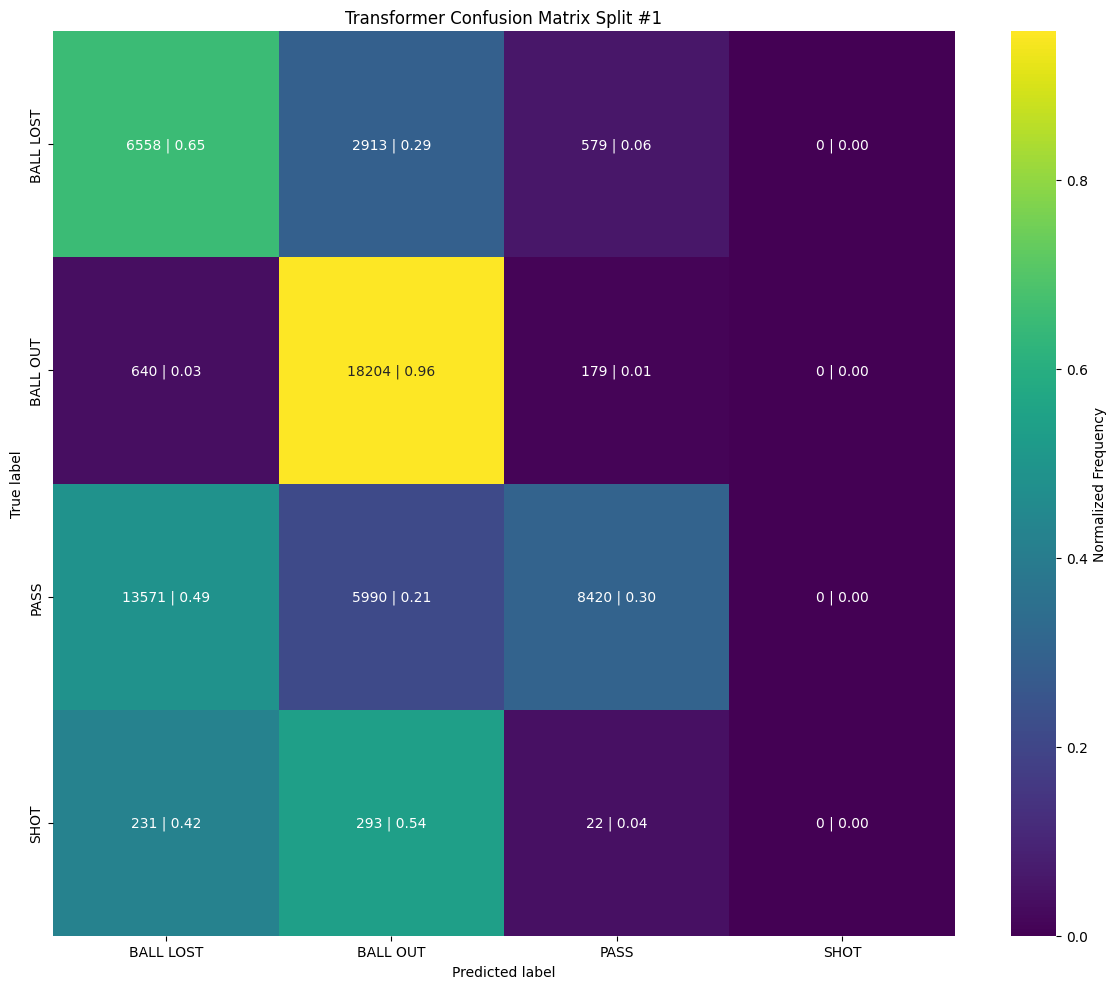

Transformer training accuracy: 94.63%
Transformer testing accuracy: 57.61%

Transformer testing precision: 71.85%
Transformer testing recall: 57.61%
Transformer testing f1: 55.27%




In [65]:
plot_accuracy_history(acc, title=f"using {str(transformer_params)}")
labels = label_encoder.inverse_transform(np.unique(y_1_encoded))
_ = plot_confusion_matrix(y_train=label_encoder.inverse_transform(y_train), y_train_pred=label_encoder.inverse_transform(y_train_pred), 
                          y_test=label_encoder.inverse_transform(y_true), y_pred=label_encoder.inverse_transform(y_pred), labels=labels, split=0, model_name="Transformer")

In [52]:
weights = torch.from_numpy(weight_1).to(device)
acc, y_train, y_train_pred, y_true, y_pred = train_model(transformer_model, train_loader, validation_loader, num_epochs, "adam", nn.CrossEntropyLoss(weight=weights), learning_rate, device, is_transformer=True)

Epoch   1/150: Train accuracy: 70.84% | Val accuracy: 70.93% | Train loss: 0.6717 | Val loss: 1.0880 | learning rate: 0.001000 | Precision: 60.97% | Recall: 70.93% | F1: 64.33%
Epoch   2/150: Train accuracy: 77.60% | Val accuracy: 67.44% | Train loss: 0.4728 | Val loss: 3.1068 | learning rate: 0.001000 | Precision: 59.87% | Recall: 67.44% | F1: 60.44%
Epoch   3/150: Train accuracy: 79.81% | Val accuracy: 75.47% | Train loss: 0.4126 | Val loss: 2.3460 | learning rate: 0.001000 | Precision: 64.64% | Recall: 75.47% | F1: 68.37%
Epoch   4/150: Train accuracy: 79.15% | Val accuracy: 62.23% | Train loss: 0.4808 | Val loss: 0.7318 | learning rate: 0.001000 | Precision: 52.12% | Recall: 62.23% | F1: 55.73%
Epoch   5/150: Train accuracy: 76.26% | Val accuracy: 63.60% | Train loss: 0.5155 | Val loss: 0.8435 | learning rate: 0.001000 | Precision: 52.56% | Recall: 63.60% | F1: 57.06%
Epoch   6/150: Train accuracy: 71.66% | Val accuracy: 50.01% | Train loss: 0.5903 | Val loss: 0.9230 | learning rat

In [ ]:
a, b, c = test_model(nn_model, validation_loader, nn.CrossEntropyLoss(weight=weights), device)

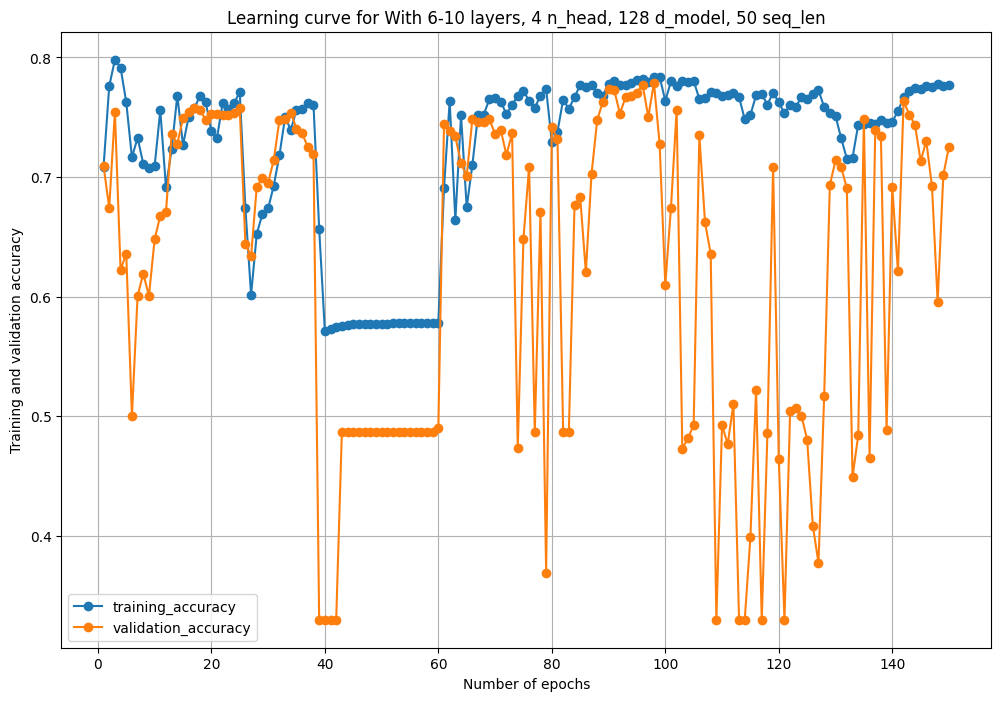

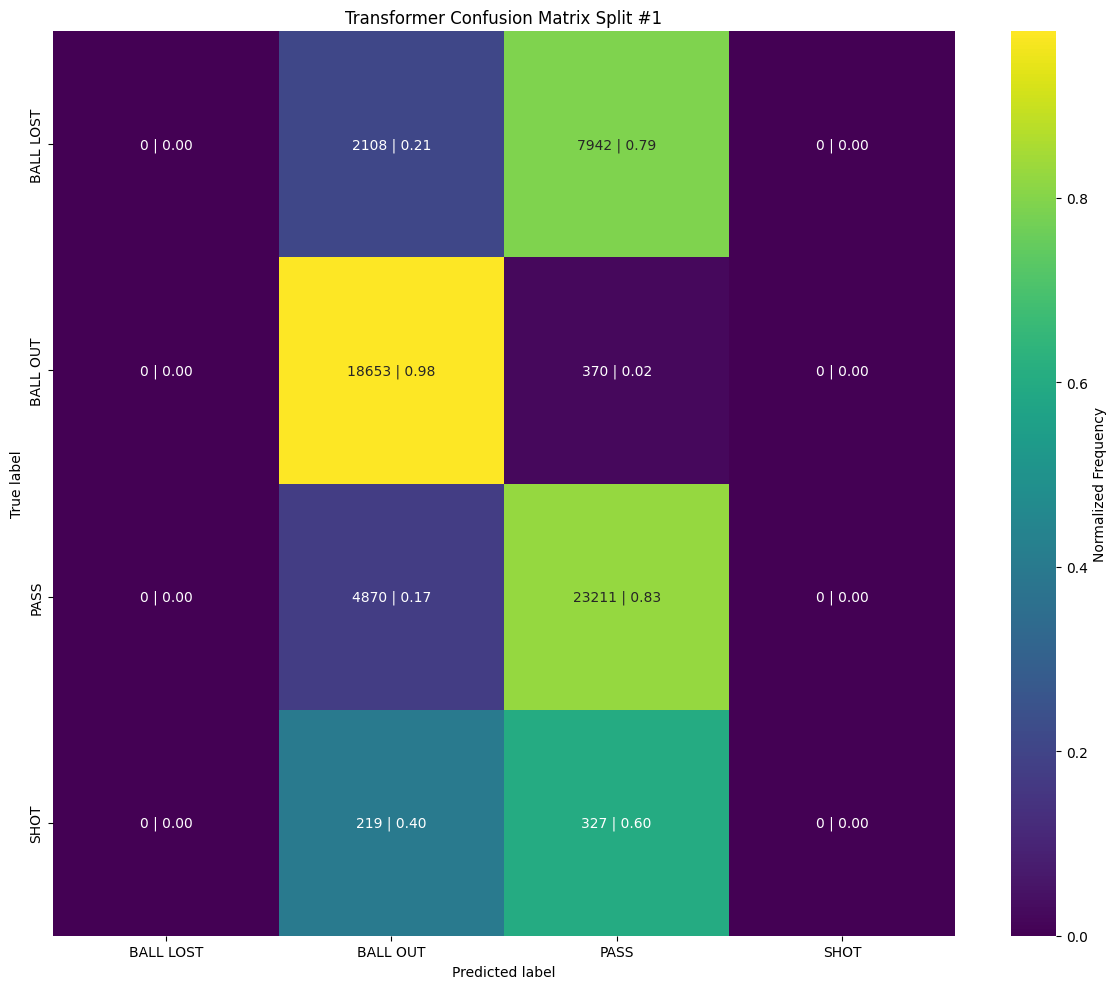

Transformer training accuracy: 77.71%
Transformer testing accuracy: 72.55%

Transformer testing precision: 59.26%
Transformer testing recall: 72.55%
Transformer testing f1: 65.11%




In [53]:
plot_accuracy_history(acc, title="With 6-10 layers, 4 n_head, 128 d_model, 50 seq_len")
labels = label_encoder.inverse_transform(np.unique(y_1_encoded))
_ = plot_confusion_matrix(y_train=label_encoder.inverse_transform(y_train), y_train_pred=label_encoder.inverse_transform(y_train_pred), 
                          y_test=label_encoder.inverse_transform(y_true), y_pred=label_encoder.inverse_transform(y_pred), labels=labels, split=0, model_name="Transformer")

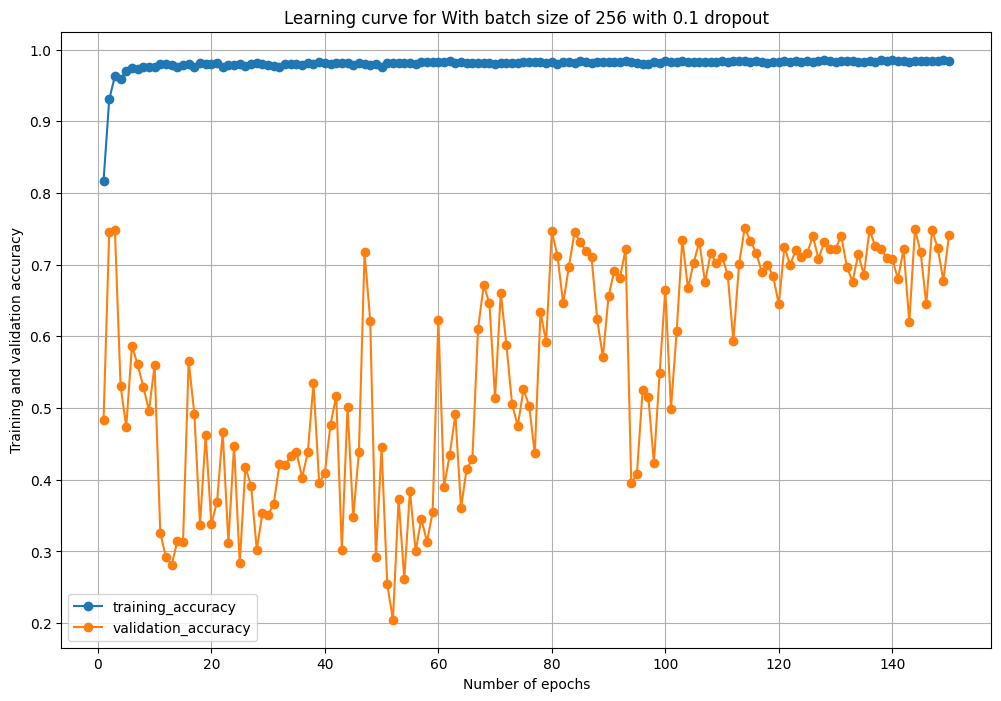

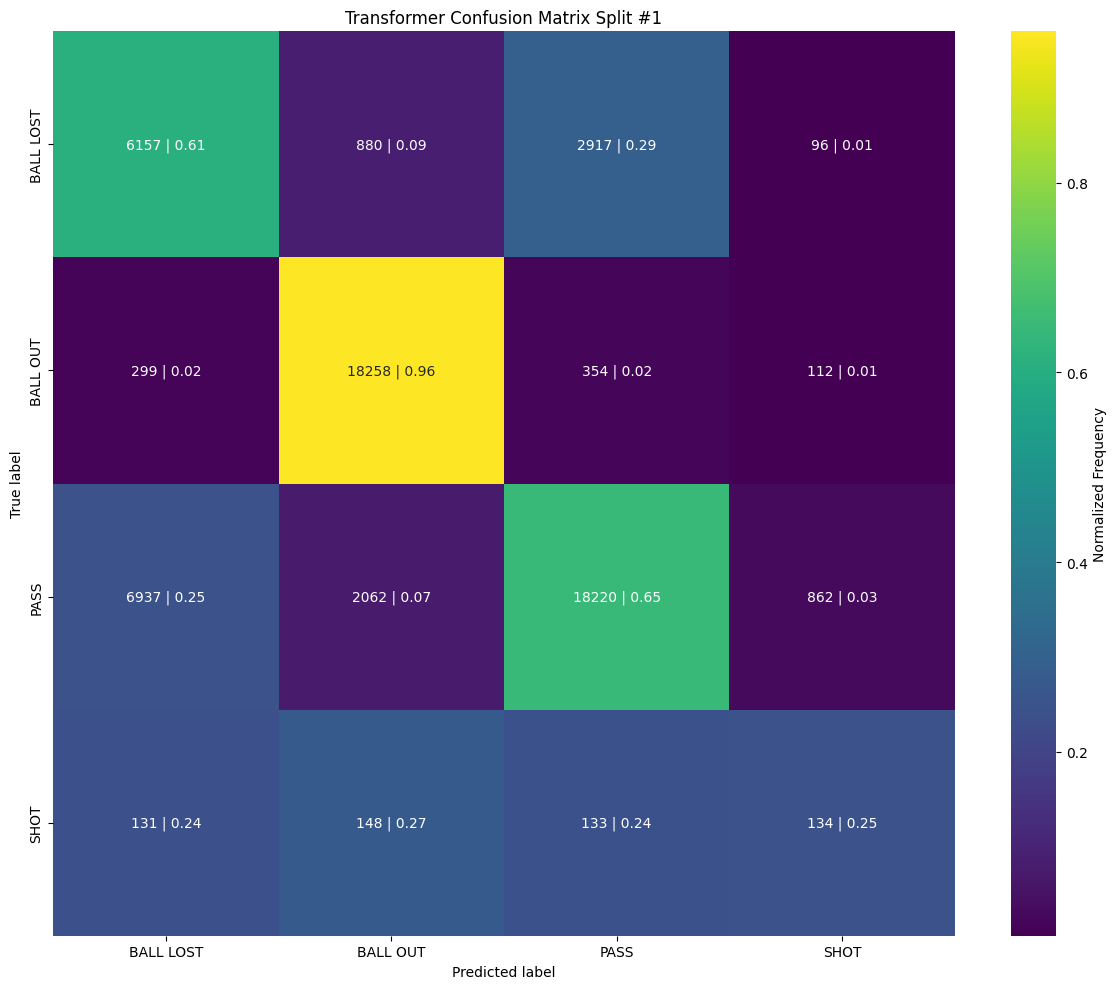

Transformer training accuracy: 98.44%
Transformer testing accuracy: 74.12%

Transformer testing precision: 77.24%
Transformer testing recall: 74.12%
Transformer testing f1: 74.74%




In [52]:
plot_accuracy_history(acc, title="With batch size of 256 with 0.1 dropout")
labels = label_encoder.inverse_transform(np.unique(y_1_encoded))
_ = plot_confusion_matrix(y_train=label_encoder.inverse_transform(y_train), y_train_pred=label_encoder.inverse_transform(y_train_pred), 
                          y_test=label_encoder.inverse_transform(y_true), y_pred=label_encoder.inverse_transform(y_pred), labels=labels, split=0, model_name="Transformer")

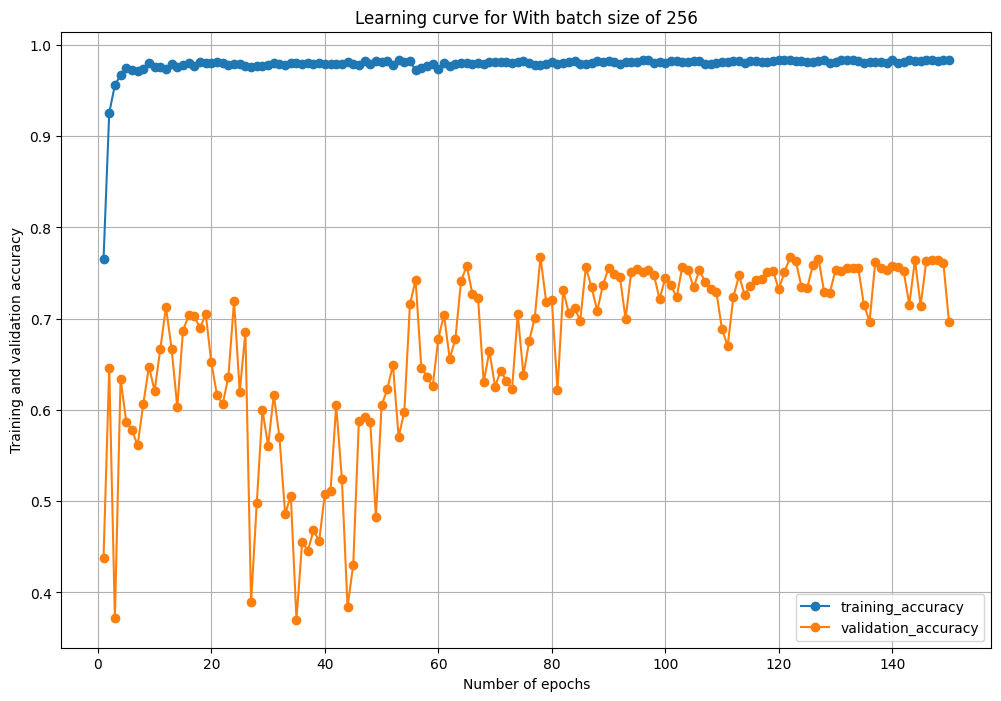

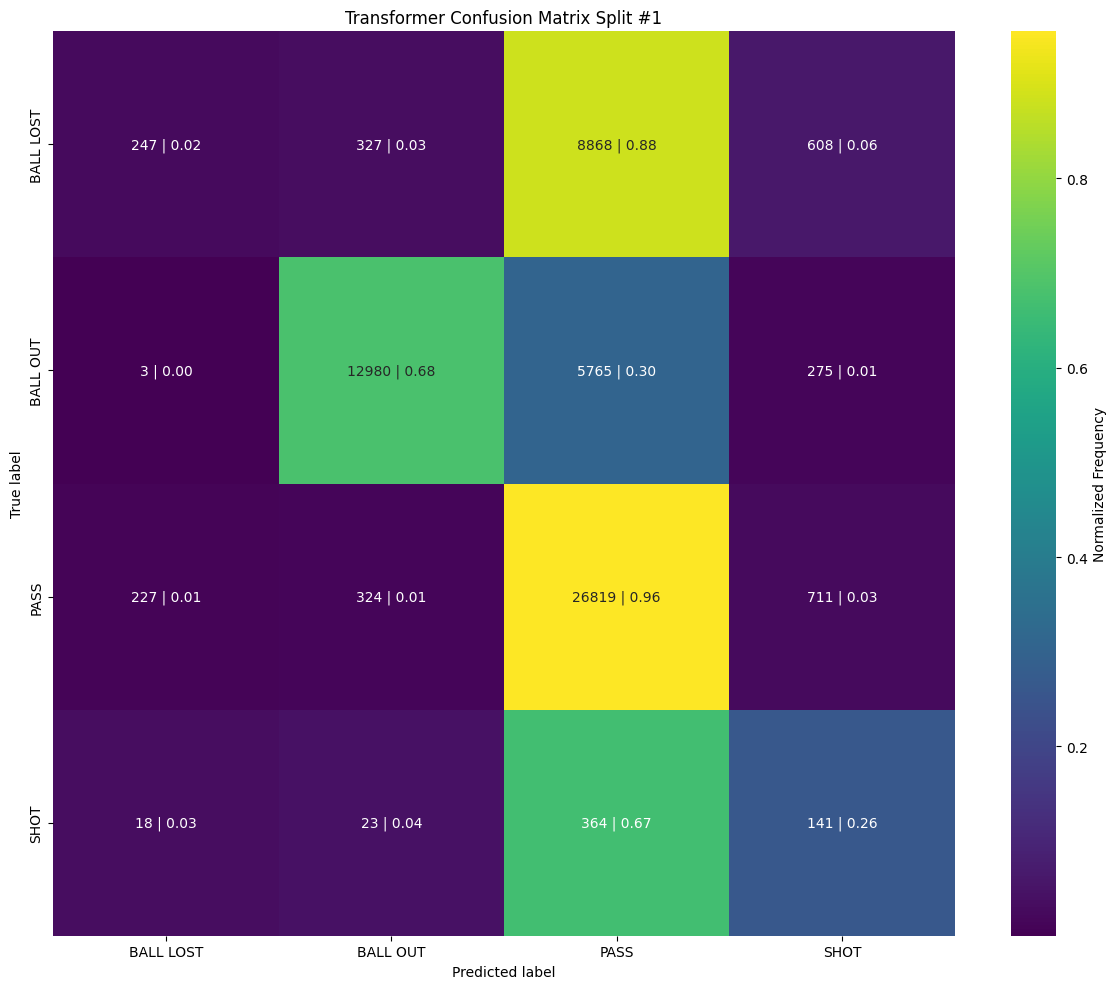

Transformer training accuracy: 98.38%
Transformer testing accuracy: 69.65%

Transformer testing precision: 71.32%
Transformer testing recall: 69.65%
Transformer testing f1: 64.47%




In [52]:
plot_accuracy_history(acc, title="With batch size of 256")
labels = label_encoder.inverse_transform(np.unique(y_1_encoded))
_ = plot_confusion_matrix(y_train=label_encoder.inverse_transform(y_train), y_train_pred=label_encoder.inverse_transform(y_train_pred), 
                          y_test=label_encoder.inverse_transform(y_true), y_pred=label_encoder.inverse_transform(y_pred), labels=labels, split=0, model_name="Transformer")

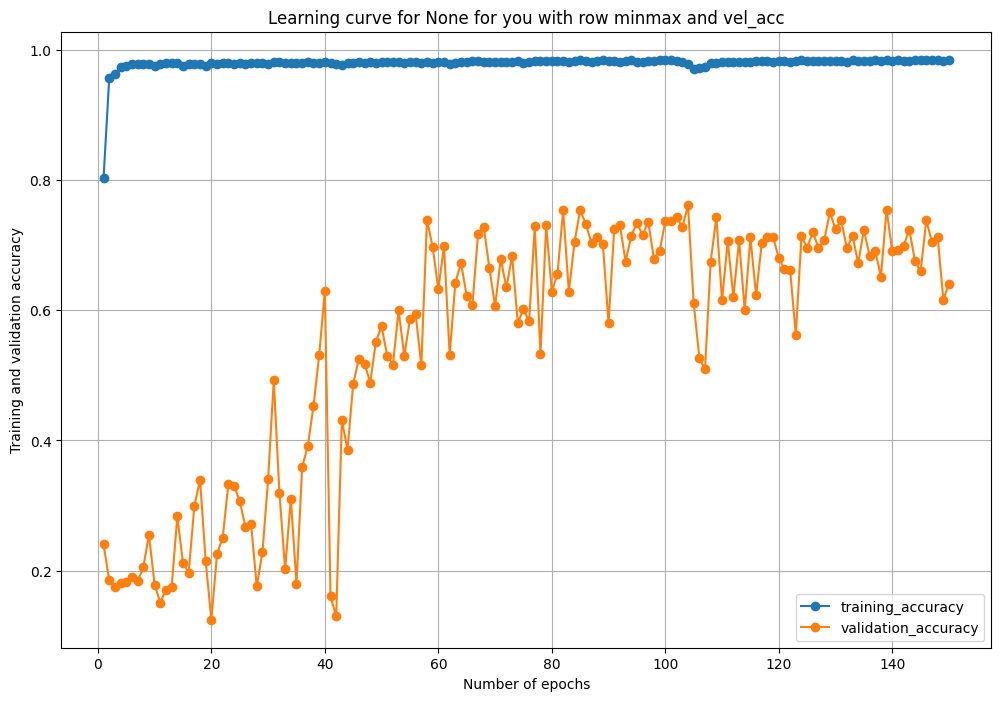

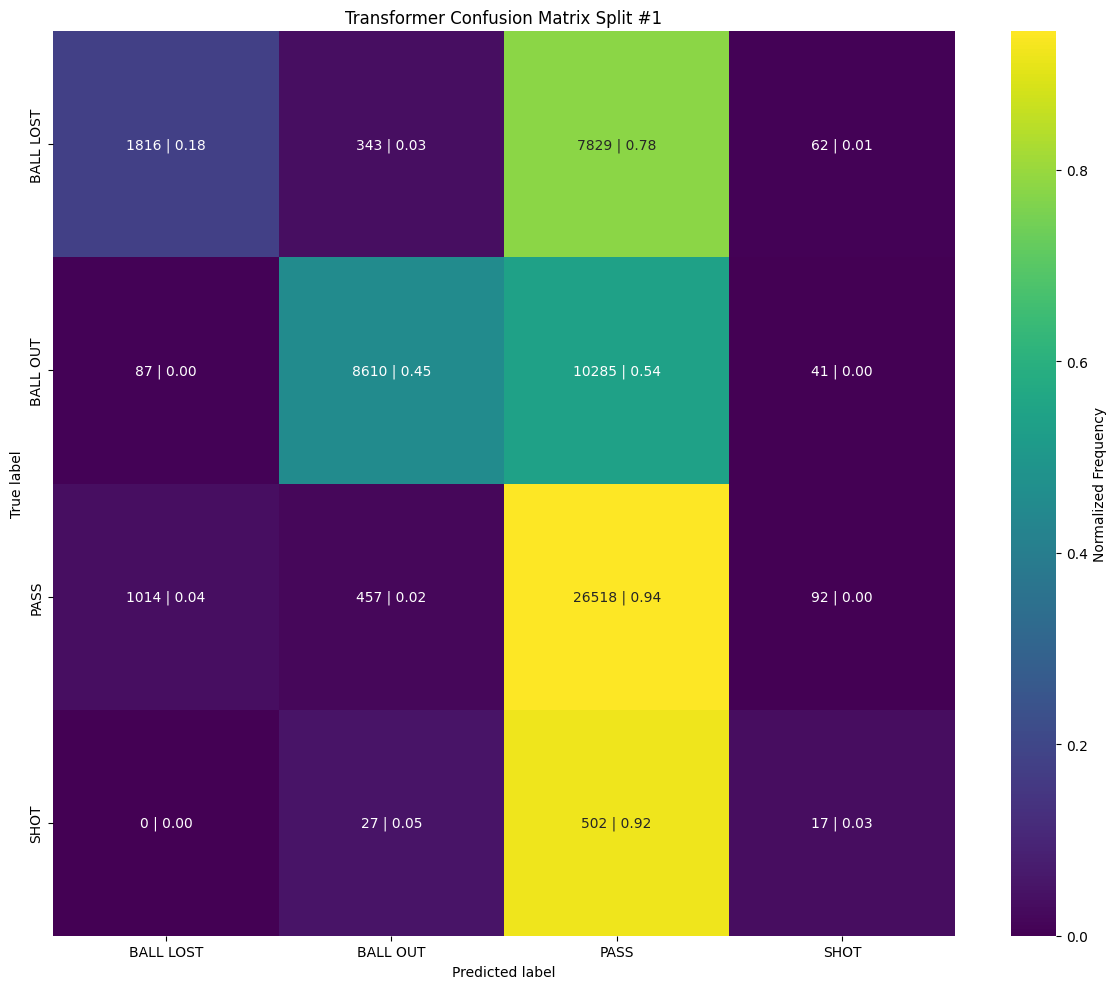

Transformer training accuracy: 98.37%
Transformer testing accuracy: 64.06%

Transformer testing precision: 69.59%
Transformer testing recall: 64.06%
Transformer testing f1: 60.12%




In [52]:
plot_accuracy_history(acc, title="None for you with row minmax and vel_acc")
labels = label_encoder.inverse_transform(np.unique(y_1_encoded))
_ = plot_confusion_matrix(y_train=label_encoder.inverse_transform(y_train), y_train_pred=label_encoder.inverse_transform(y_train_pred), 
                          y_test=label_encoder.inverse_transform(y_true), y_pred=label_encoder.inverse_transform(y_pred), labels=labels, split=0, model_name="Transformer")

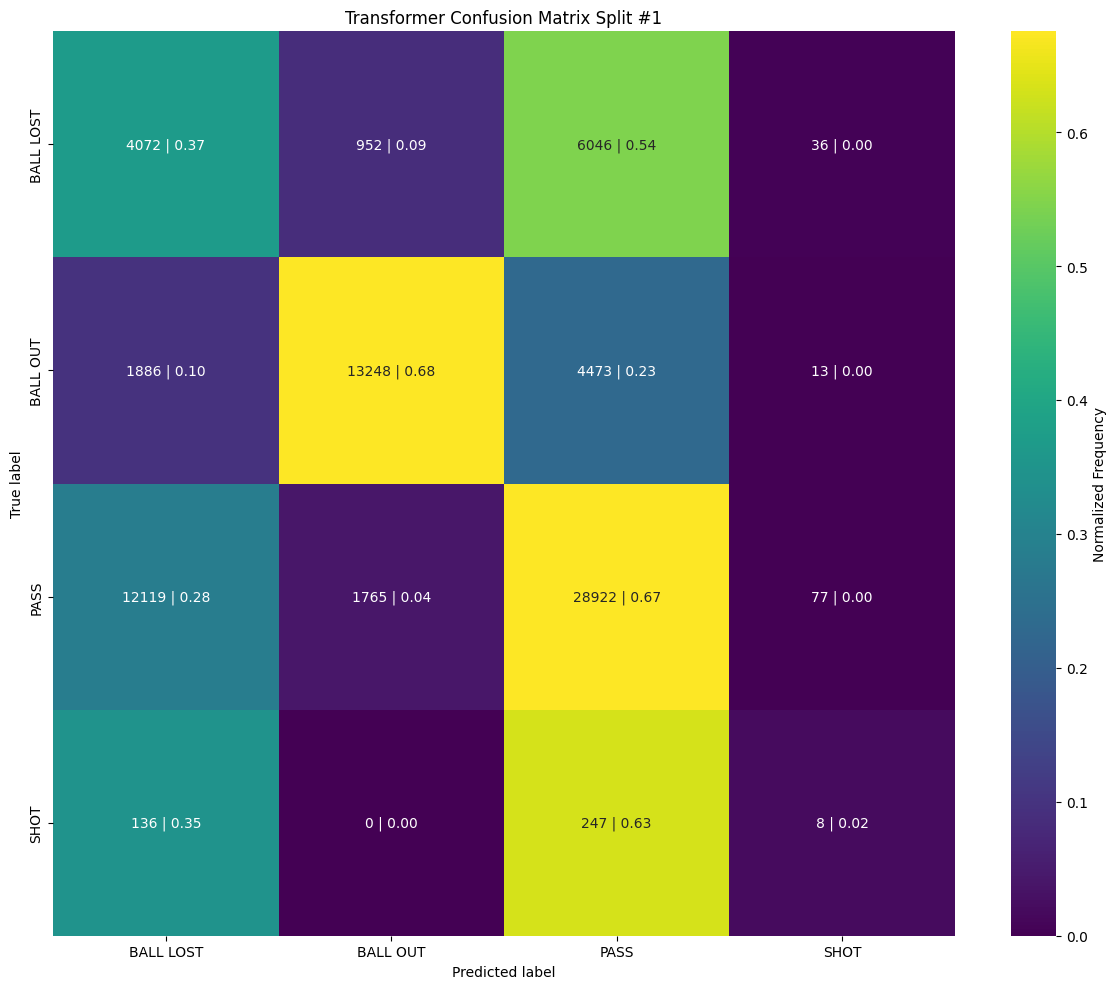

Transformer training accuracy: 97.84%
Transformer testing accuracy: 62.50%

Transformer testing precision: 67.62%
Transformer testing recall: 62.50%
Transformer testing f1: 64.52%


